In [1]:
#Imports
import os
import torch
import random
import numpy as np
import pandas
import gc
import shutil
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torch.nn.functional as F
from torchvision.io import decode_image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
if not os.path.exists("/content/resources.zip"): shutil.copy("/content/drive/MyDrive/resources.zip", "/content/")
if not os.path.exists("/content/resources"): shutil.unpack_archive("/content/resources.zip", "/content/resources")

In [3]:
#Dataset
class SkinDiseaseDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.labels_map={}
        labels_list=[]
        num=0
        for dir in os.listdir(self.img_dir):
            category=dir
            self.labels_map[num]=category
            for file in os.listdir(os.path.join(img_dir, dir)):
                labels_list.append((file, num))
            num+=1
        self.img_labels=pandas.DataFrame.from_records(labels_list)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.labels_map[self.img_labels.iloc[idx, 1]], self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
#Testing utilities
def train(model, dataset, EPOCHS, batch_size, optimizer, criterion, device, transform):
    train_dataset=SkinDiseaseDataset(os.path.join(dataset, "train"), transform=transform)
    train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dataset=SkinDiseaseDataset(os.path.join(dataset, "validation"), transform=transform)
    val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    history = {
        'train_loss': [],
        'train_acc': [],
        'dev_loss': [],
        'dev_acc': [],
    }

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Limpiar gradientes
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward
            n_classes = outputs.shape[1]
            labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()

            loss = criterion(outputs, labels_one_hot)  # Pérdida
            loss.backward()  # Backward
            optimizer.step()  # Update

            running_loss += loss.item()

            # Accuracy en train
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / max(1, len(train_loader))
        train_acc = 100.0 * correct / max(1, total)

        # ---- Validación (loss) ----
        model.eval()
        dev_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                n_classes = outputs.shape[1]
                labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()
                dev_loss = criterion(outputs, labels_one_hot)
                dev_running_loss += dev_loss.item()
        avg_dev_loss = dev_running_loss / max(1, len(val_loader))

        # ---- Validación (accuracy) usando tu función evaluate ----
        dev_acc = evaluate(model, device, os.path.join(dataset, "validation"), batch_size, transform)[0]  # imprime y devuelve accuracy

        # Guardar histórico
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        # Log por época (conciso y claro)
        print(f'[Epoch {epoch + 1}] '
              f'train_loss: {avg_train_loss:.3f} | train_acc: {train_acc:.2f}% | '
              f'dev_loss: {avg_dev_loss:.3f} | dev_acc: {dev_acc:.2f}%')

    return model, history

def evaluate(model, device, data, BATCH_SIZE, transform):
    test_dataset=SkinDiseaseDataset(data, transform=transform)
    test_loader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = test_loader.dataset.__len__()  # Total de muestras en el conjunto de test
    all_preds = []
    all_labels = []
    with torch.no_grad():  # No calcular gradientes
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover datos al dispositivo
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Obtener las predicciones
            correct += (predicted == labels).sum().item()  # Actualizar el contador de aciertos
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = 100 * correct / total if total > 0 else 0.0
    return accuracy, cm

def plot_training_history(history):
    """
    Dibuja las curvas de loss y accuracy (train y dev) guardadas en el diccionario 'history'.
    Espera claves: 'train_loss', 'train_acc', 'dev_loss', 'dev_acc'.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Loss ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['dev_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['dev_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def print_cm(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def runNN(model, DEVICE, data, epochs, BATCH_SIZE, optimizer, loss, transform):
    classes=[]
    for dir in os.listdir(os.path.join(data, "test")): classes.append(dir)
    model, history=train(model, data, epochs, BATCH_SIZE, optimizer, loss, DEVICE, transform)
    accuracy, cm=evaluate(model, DEVICE, os.path.join(data, "test"), BATCH_SIZE, transform)
    print(f"eval_acc: {accuracy:.2f}%")
    plot_training_history(history)
    print_cm(cm, classes)

[Epoch 1] train_loss: 2.337 | train_acc: 12.26% | dev_loss: 2.318 | dev_acc: 14.26%
[Epoch 2] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.318 | dev_acc: 14.26%
[Epoch 3] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.319 | dev_acc: 14.26%
[Epoch 4] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.319 | dev_acc: 14.26%
[Epoch 5] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.318 | dev_acc: 14.26%
eval_acc: 13.04%


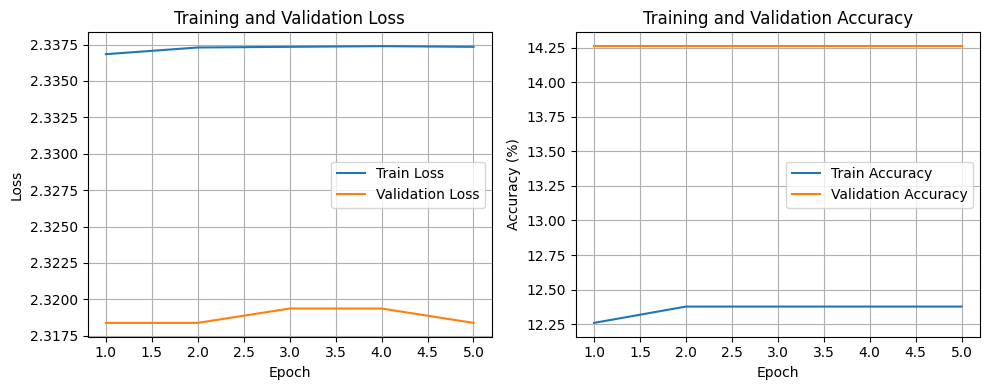

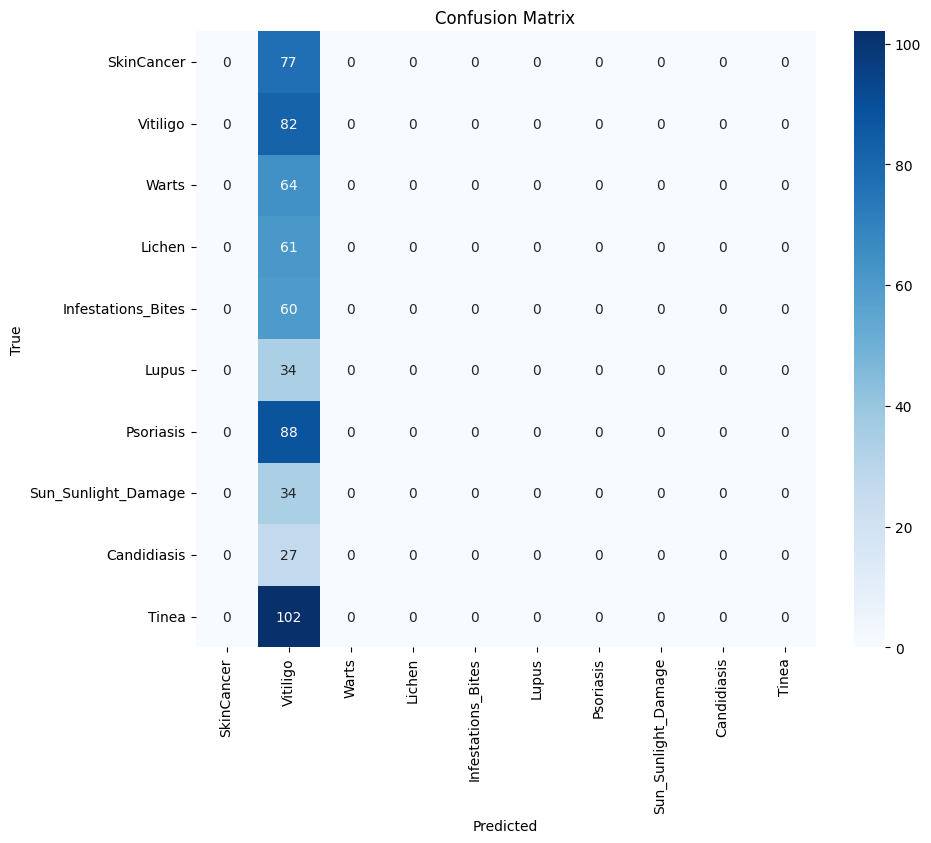

In [ ]:
#Prueba no convolutiva
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.activation=nn.Sigmoid()
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return self.softmax(x)

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=SimpleNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 5, 32, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((82, 87)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

[Epoch 1] train_loss: 215.803 | train_acc: 11.51% | dev_loss: 79.930 | dev_acc: 6.21%
[Epoch 2] train_loss: 155.609 | train_acc: 11.53% | dev_loss: 144.198 | dev_acc: 14.26%
[Epoch 3] train_loss: 160.358 | train_acc: 10.98% | dev_loss: 145.824 | dev_acc: 10.57%
[Epoch 4] train_loss: 158.125 | train_acc: 12.34% | dev_loss: 170.358 | dev_acc: 10.57%
[Epoch 5] train_loss: 153.997 | train_acc: 11.24% | dev_loss: 164.176 | dev_acc: 6.21%
eval_acc: 5.41%


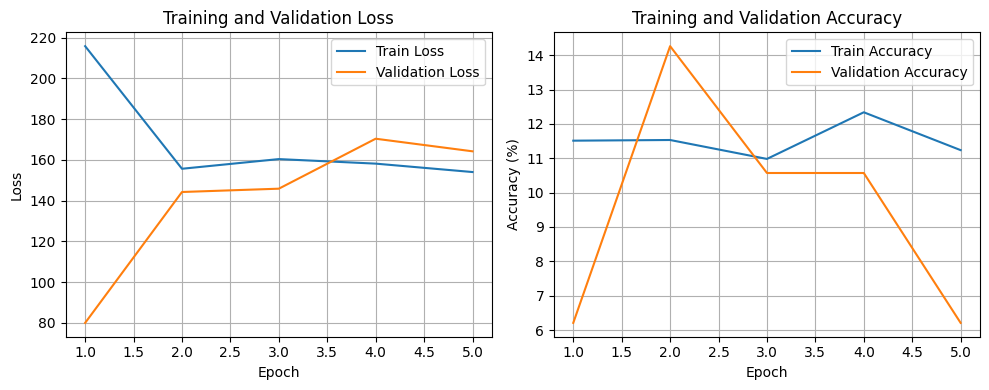

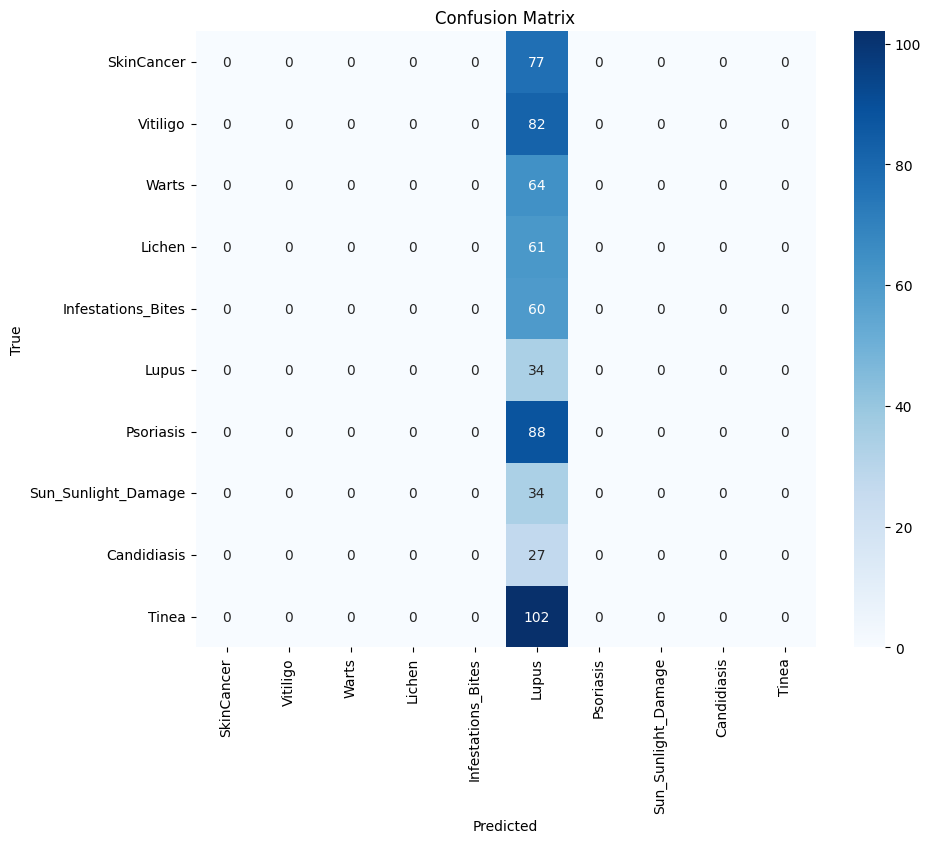

In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super(ConvNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.pool=nn.MaxPool2d(2, 2)
        self.activation=nn.Sigmoid()

    def forward(self, x):
        x=self.pool(self.activation(self.conv1(x)))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=ConvNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 5, 32, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((82, 87)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

[Epoch 1] train_loss: 296.747 | train_acc: 11.81% | dev_loss: 185.796 | dev_acc: 11.24%
[Epoch 2] train_loss: 275.290 | train_acc: 11.90% | dev_loss: 356.440 | dev_acc: 9.56%
[Epoch 3] train_loss: 227.345 | train_acc: 11.22% | dev_loss: 228.620 | dev_acc: 6.88%
[Epoch 4] train_loss: 211.676 | train_acc: 11.92% | dev_loss: 207.916 | dev_acc: 19.30%
[Epoch 5] train_loss: 187.484 | train_acc: 12.12% | dev_loss: 118.458 | dev_acc: 10.57%
eval_acc: 10.33%


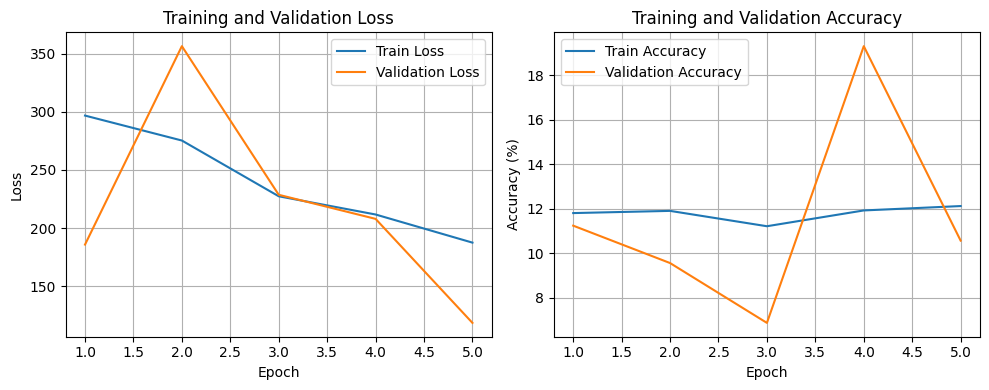

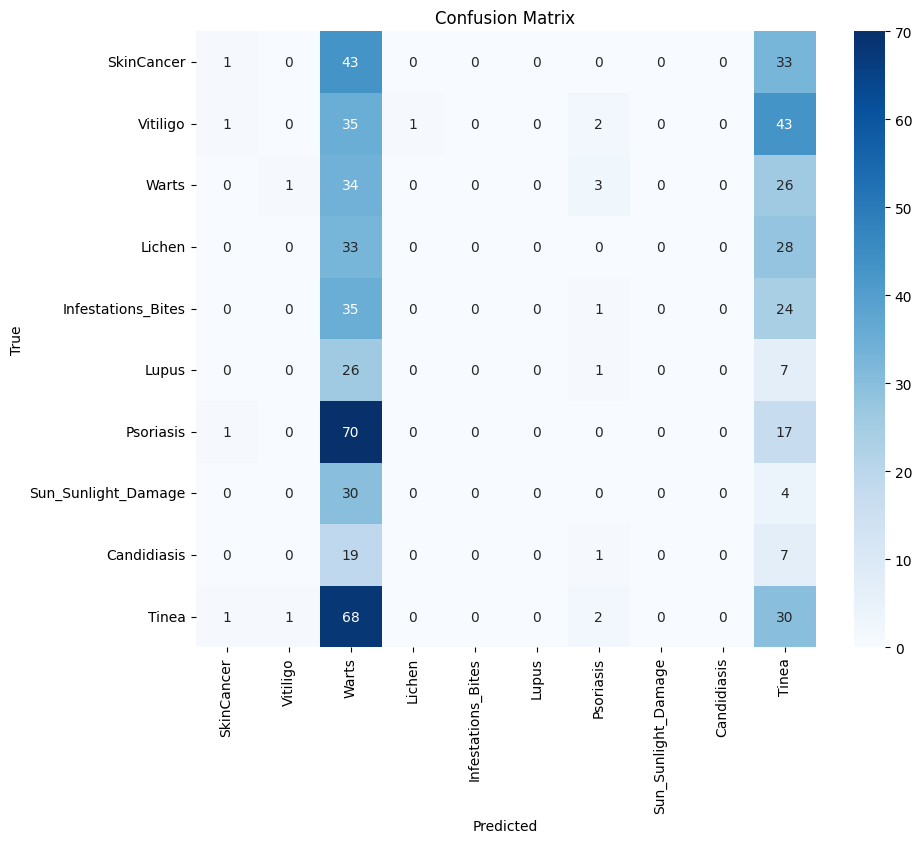

In [ ]:
class TanhNetwork(nn.Module):
    def __init__(self):
        super(TanhNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.pool=nn.MaxPool2d(2, 2)
        self.activation=nn.Tanh()

    def forward(self, x):
        x=self.pool(self.activation(self.conv1(x)))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=TanhNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 5, 16, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((82, 87)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

[Epoch 1] train_loss: 334.448 | train_acc: 11.10% | dev_loss: 433.226 | dev_acc: 13.93%
[Epoch 2] train_loss: 317.481 | train_acc: 11.12% | dev_loss: 333.948 | dev_acc: 10.57%
[Epoch 3] train_loss: 308.672 | train_acc: 11.77% | dev_loss: 257.428 | dev_acc: 14.26%
[Epoch 4] train_loss: 325.540 | train_acc: 11.26% | dev_loss: 273.848 | dev_acc: 11.07%
[Epoch 5] train_loss: 203.098 | train_acc: 11.35% | dev_loss: 259.397 | dev_acc: 8.39%
[Epoch 6] train_loss: 183.031 | train_acc: 10.61% | dev_loss: 104.783 | dev_acc: 16.95%
eval_acc: 14.47%


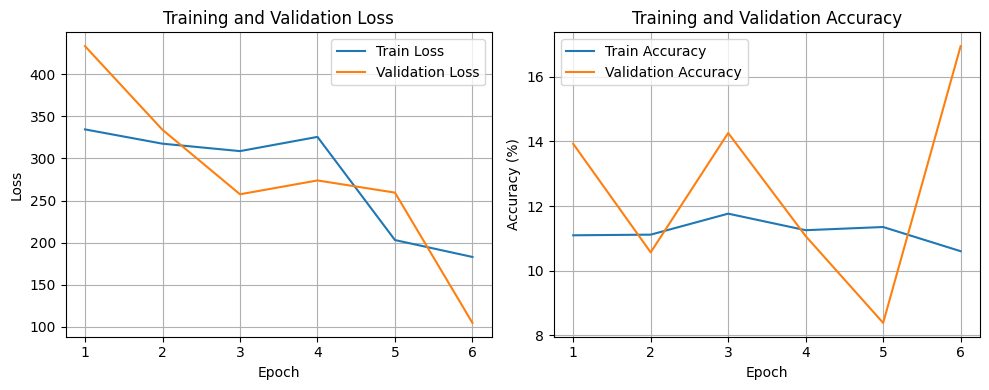

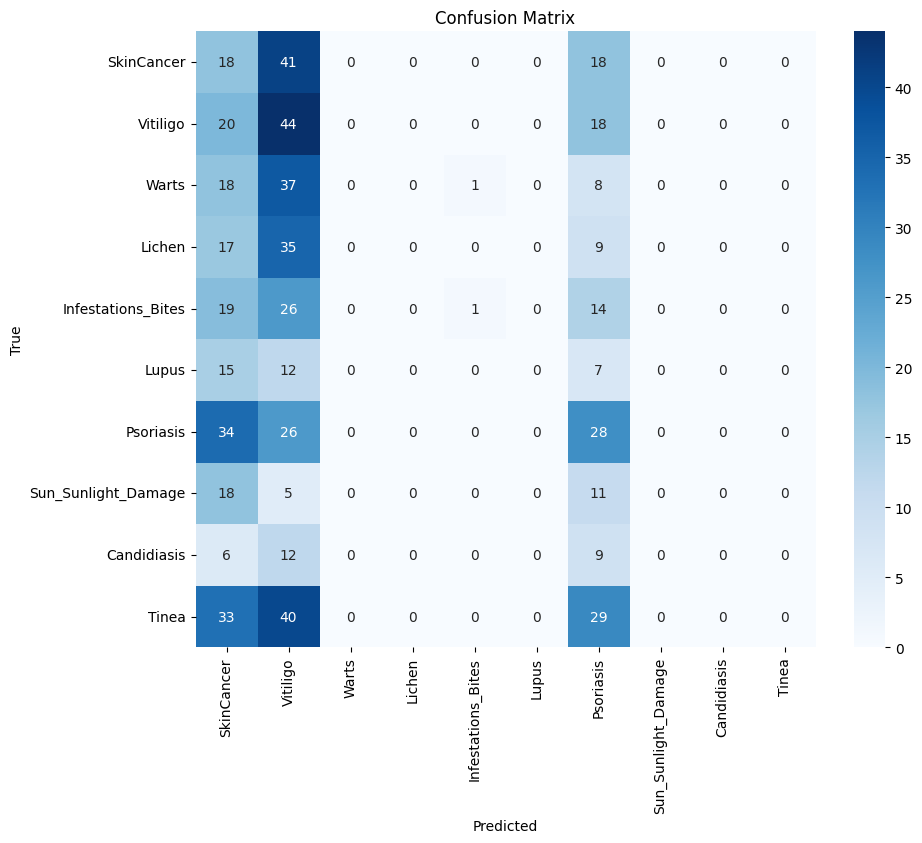

In [ ]:
class NoPoolNetwork(nn.Module):
    def __init__(self):
        super(NoPoolNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        #self.pool=nn.MaxPool2d(2, 2)
        self.activation=nn.Tanh()

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=NoPoolNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 6, 16, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

[Epoch 1] train_loss: 161.501 | train_acc: 11.69% | dev_loss: 279.512 | dev_acc: 14.26%
[Epoch 2] train_loss: 131.891 | train_acc: 11.90% | dev_loss: 238.707 | dev_acc: 11.58%
[Epoch 3] train_loss: 151.571 | train_acc: 11.90% | dev_loss: 99.239 | dev_acc: 6.54%
[Epoch 4] train_loss: 129.580 | train_acc: 11.28% | dev_loss: 115.002 | dev_acc: 14.77%
[Epoch 5] train_loss: 143.038 | train_acc: 12.16% | dev_loss: 236.687 | dev_acc: 10.07%
[Epoch 6] train_loss: 139.166 | train_acc: 12.02% | dev_loss: 127.935 | dev_acc: 16.28%
eval_acc: 15.90%


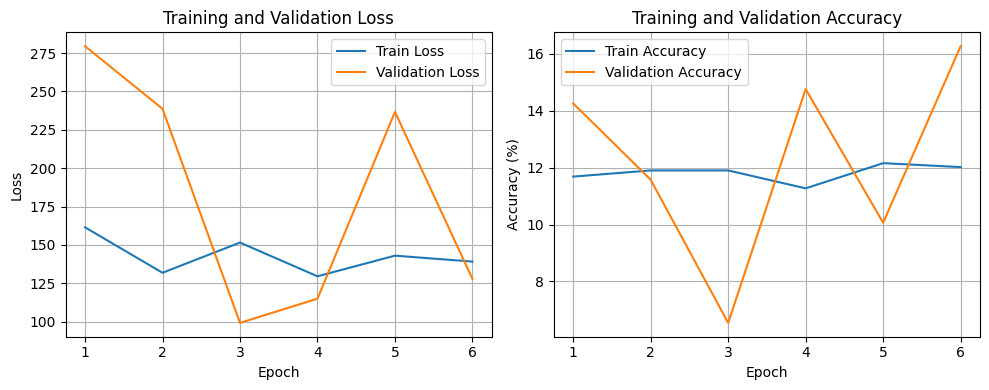

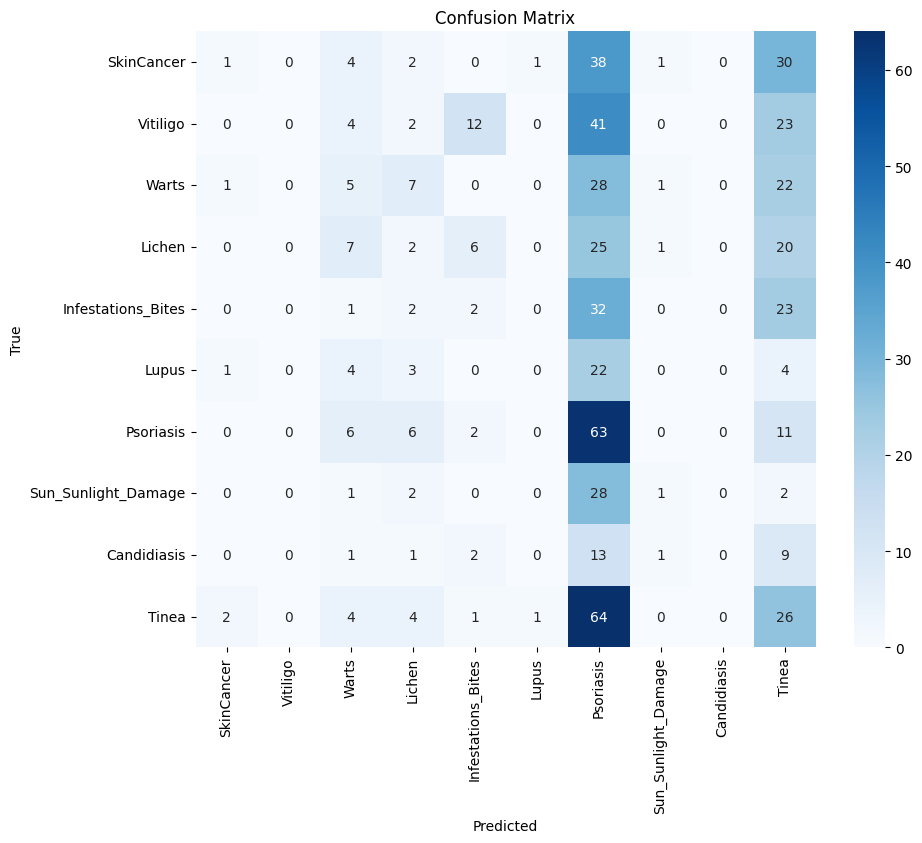

In [ ]:
class DropoutNetwork(nn.Module):
    def __init__(self):
        super(DropoutNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.activation=nn.Tanh()
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.dropout(x)
        x=self.fc2(self.activation(x))
        x=self.dropout(x)
        x=self.fc3(self.activation(x))
        x=self.dropout(x)
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=DropoutNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 6, 16, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

[Epoch 1] train_loss: 2.162 | train_acc: 23.12% | dev_loss: 2.029 | dev_acc: 31.38%
[Epoch 2] train_loss: 2.039 | train_acc: 26.92% | dev_loss: 2.042 | dev_acc: 28.69%
[Epoch 3] train_loss: 1.988 | train_acc: 29.22% | dev_loss: 1.934 | dev_acc: 30.87%
[Epoch 4] train_loss: 1.918 | train_acc: 32.70% | dev_loss: 1.899 | dev_acc: 34.73%
[Epoch 5] train_loss: 1.865 | train_acc: 34.53% | dev_loss: 1.886 | dev_acc: 34.06%
[Epoch 6] train_loss: 1.789 | train_acc: 37.64% | dev_loss: 1.907 | dev_acc: 33.72%
[Epoch 7] train_loss: 1.746 | train_acc: 38.47% | dev_loss: 2.015 | dev_acc: 31.71%
[Epoch 8] train_loss: 1.686 | train_acc: 41.44% | dev_loss: 1.906 | dev_acc: 35.57%
[Epoch 9] train_loss: 1.619 | train_acc: 43.45% | dev_loss: 1.841 | dev_acc: 39.09%
[Epoch 10] train_loss: 1.545 | train_acc: 46.50% | dev_loss: 1.895 | dev_acc: 38.26%
[Epoch 11] train_loss: 1.479 | train_acc: 49.11% | dev_loss: 1.890 | dev_acc: 36.91%
[Epoch 12] train_loss: 1.405 | train_acc: 51.79% | dev_loss: 1.910 | dev_a

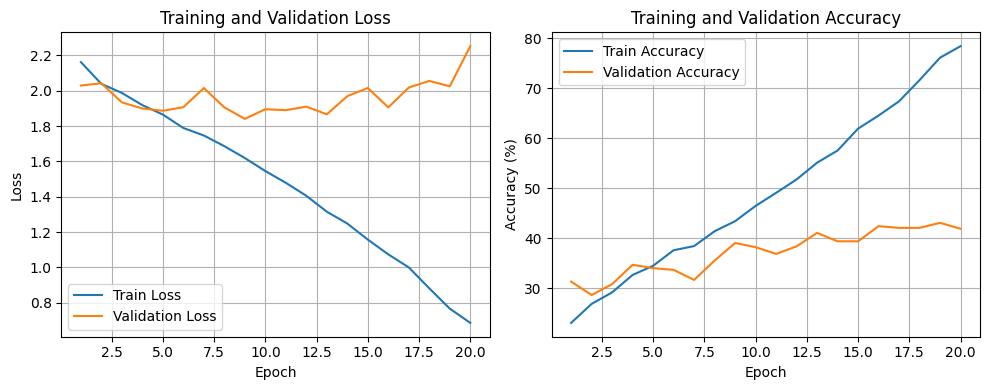

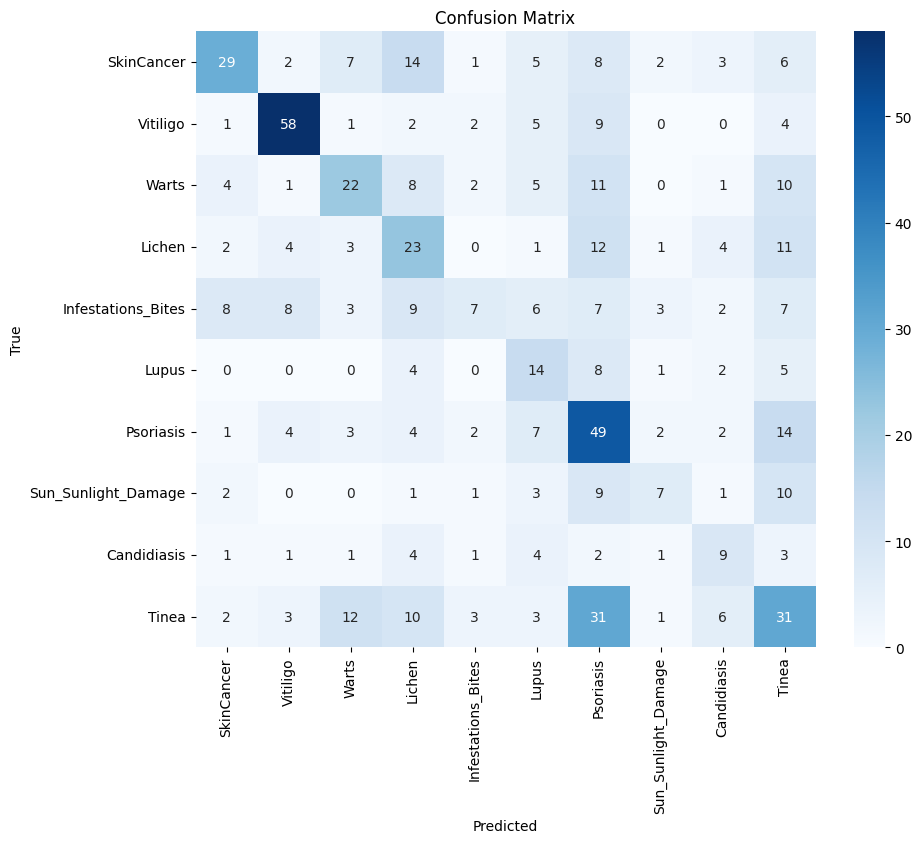

In [ ]:
class AdjustedNetwork(nn.Module):
    def __init__(self):
        super(AdjustedNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.activation=nn.Tanh()
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.dropout(x)
        x=self.fc2(self.activation(x))
        x=self.dropout(x)
        x=self.fc3(self.activation(x))
        x=self.dropout(x)
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AdjustedNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 20, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_swag-c8ce3e52.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_swag-c8ce3e52.pth


100%|██████████| 2.40G/2.40G [01:03<00:00, 40.5MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

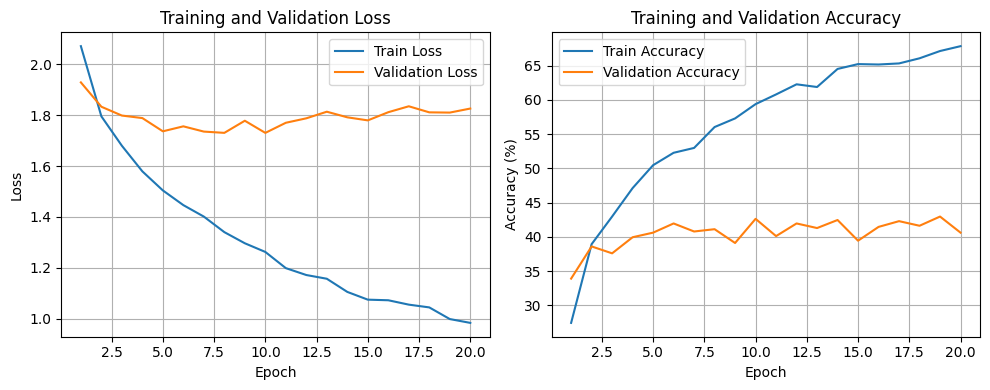

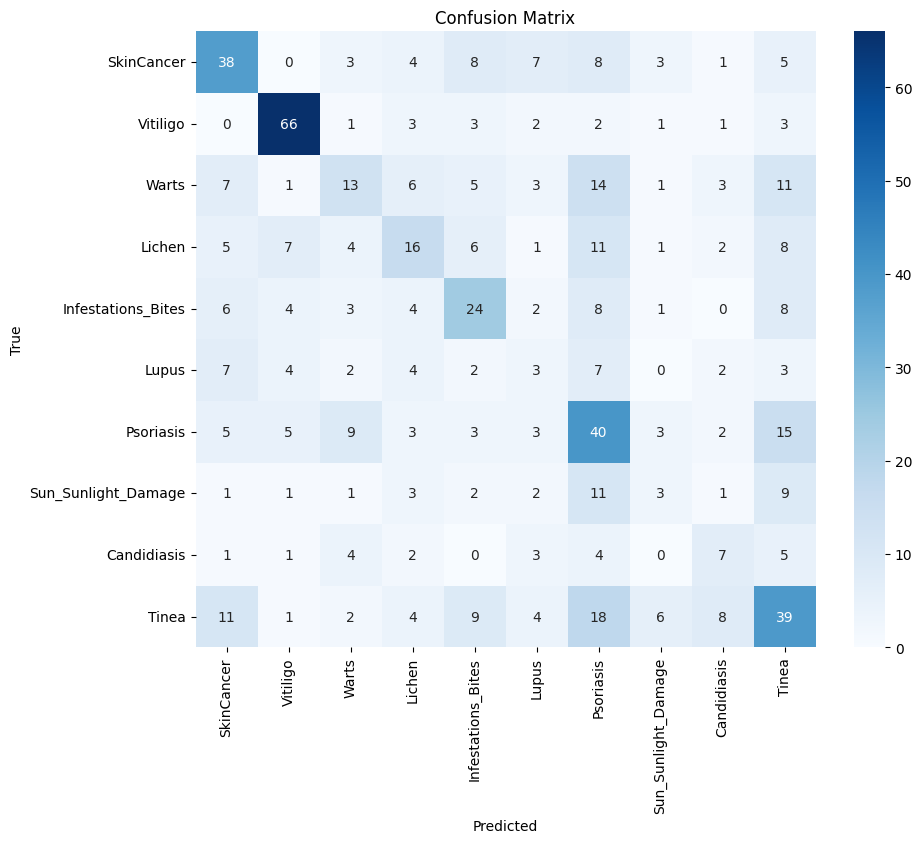

In [ ]:
seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.regnet_y_128gf(weights="IMAGENET1K_SWAG_E2E_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc=nn.Sequential(
    nn.LazyLinear(512),
    nn.Tanh(),
    nn.Dropout(0.2),
    nn.LazyLinear(10)
)
model.to(DEVICE)
print(model)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 20, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

[Epoch 1] train_loss: 2.727 | train_acc: 19.05% | dev_loss: 2.638 | dev_acc: 21.17%
[Epoch 2] train_loss: 2.570 | train_acc: 22.88% | dev_loss: 2.588 | dev_acc: 23.43%
[Epoch 3] train_loss: 2.499 | train_acc: 25.53% | dev_loss: 2.553 | dev_acc: 25.18%
[Epoch 4] train_loss: 2.436 | train_acc: 26.98% | dev_loss: 2.540 | dev_acc: 26.86%
[Epoch 5] train_loss: 2.364 | train_acc: 29.10% | dev_loss: 2.577 | dev_acc: 26.66%
[Epoch 6] train_loss: 2.304 | train_acc: 30.89% | dev_loss: 2.470 | dev_acc: 27.70%
[Epoch 7] train_loss: 2.238 | train_acc: 32.79% | dev_loss: 2.538 | dev_acc: 27.50%
[Epoch 8] train_loss: 2.177 | train_acc: 34.42% | dev_loss: 2.393 | dev_acc: 30.02%
[Epoch 9] train_loss: 2.100 | train_acc: 36.58% | dev_loss: 2.371 | dev_acc: 29.89%
[Epoch 10] train_loss: 2.027 | train_acc: 38.76% | dev_loss: 2.379 | dev_acc: 31.31%
[Epoch 11] train_loss: 1.933 | train_acc: 41.79% | dev_loss: 2.420 | dev_acc: 30.15%
[Epoch 12] train_loss: 1.877 | train_acc: 43.58% | dev_loss: 2.355 | dev_a

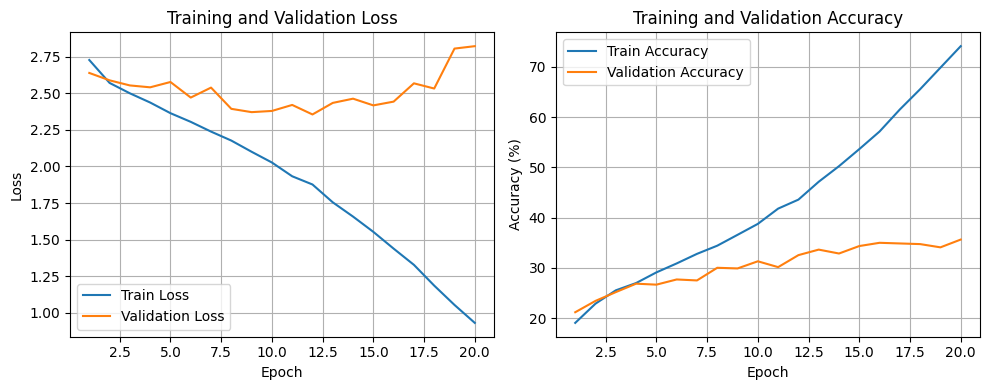

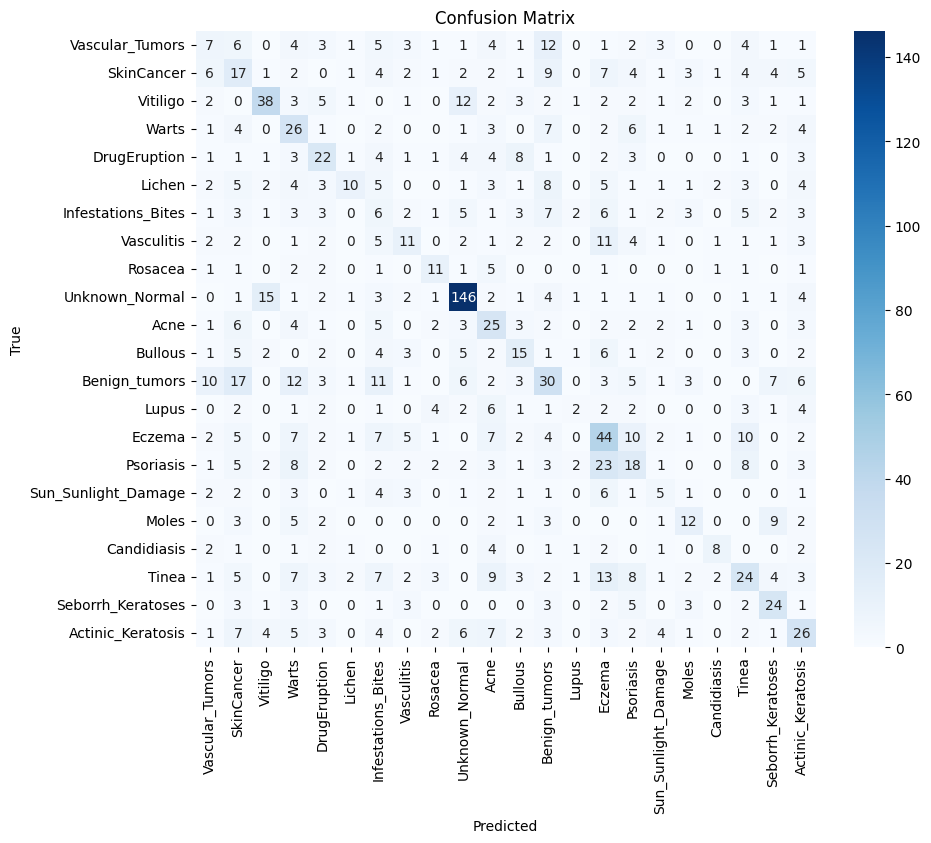

In [5]:
class AdjustedNetwork(nn.Module):
    def __init__(self):
        super(AdjustedNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(22)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.activation=nn.Tanh()
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.dropout(x)
        x=self.fc2(self.activation(x))
        x=self.dropout(x)
        x=self.fc3(self.activation(x))
        x=self.dropout(x)
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AdjustedNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(22 clases)"), 20, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_swag-c8ce3e52.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_swag-c8ce3e52.pth


100%|██████████| 2.40G/2.40G [00:35<00:00, 73.0MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

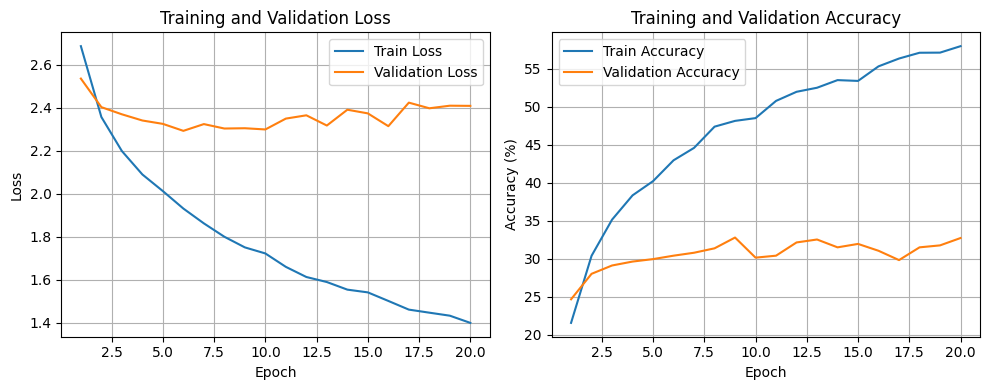

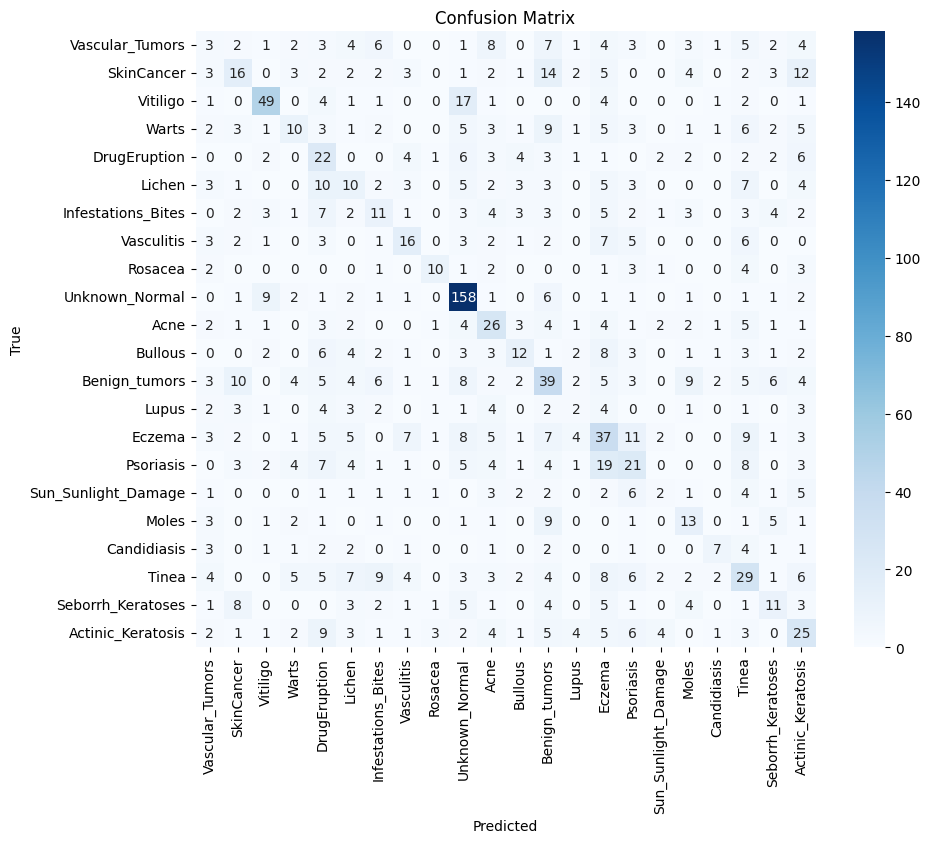

In [6]:
seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.regnet_y_128gf(weights="IMAGENET1K_SWAG_E2E_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc=nn.Sequential(
    nn.LazyLinear(512),
    nn.Tanh(),
    nn.Dropout(0.2),
    nn.LazyLinear(22)
)
model.to(DEVICE)
print(model)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(22 clases)"), 20, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))